<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Ambarish Moharil

# Student 2: Kunal Geed

# Student 3: Mert Lostar

# Imports

In [ ]:
import numpy as np
import pickle
import requests

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# other imports go here

# Data loading and inspection

In [ ]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [ ]:
#Let's see how the full dataset looks like.

full_data.keys()

#unlabelled dataset - 26000 Images in distribution that are not labellled.

#labeled dataset - 2000 Images that are in distribution and labelled

#representatiive set1 and set2 - 1052 data points each which contain roughly 5% out-of-
#                      distribution data and which are fully labeled (anomalies being 
#                       labeled as a sixth class).

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [ ]:

train_data = full_data["unlabeled_data"]/255.0 #train on the 26000 in distribution images, normalizing(/255)



In [ ]:
#We have a set of 2000 images that are in distribution and labelled. We will now train these images 

cl_train_data_full = full_data["labeled_data"]["data"]/255.0 #Normalize the dataset
cl_train_targets = full_data["labeled_data"]["labels"]
dummy_class = np.zeros((2000,1))
cl_train_full_targets = np.concatenate((cl_train_targets, dummy_class), axis =1)

In [ ]:
#We need to create a train and a validation set for the classification task.

from sklearn.model_selection import train_test_split

cl_train_data, cl_valid_data, cl_train_labels, cl_valid_labels = train_test_split(cl_train_data_full, cl_train_full_targets, test_size = 0.3, random_state = 69 )


In [ ]:
#We use the representative sets as a test set for our classifier, we remove the anmolies from this set.

test_set_1 = full_data["representative_set_1"]["data"]/255.0 #get the data from first repres set
test_set_2 = full_data["representative_set_2"]["data"]/255.0 # get the data from the second repres set

test_labels_set1 = full_data["representative_set_1"]["labels"] #get the labels from rep set 1
test_labels_set2 = full_data["representative_set_2"]["labels"] #get the resp labels from rep set 2


#Do not merge the sets
# cl_test_set = np.concatenate((test_set_1, test_set_2), axis =0) # concatenate those two sets for testing
#                                                                       # [2104, 1, 32, 32]
# cl_test_labels = np.concatenate((test_labels_set1, test_labels_set2), axis =0)# get the respective labels


normal_idx = np.array(np.where(test_labels_set2[:,5] ==0)).flatten()
normal_samples = SubsetRandomSampler(normal_idx)

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
        
    def __getitem__(self, index):
        x = self.data[index]

        return index, x
    
    def __len__(self):
        return len(self.data)

class GeneralDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.FloatTensor(data)
        self.target  = torch.FloatTensor(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
#Create the dataloaders
train_dataset = TrainDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size= 10)


cl_train_dataset = GeneralDataset(cl_train_data, cl_train_labels)
cl_train_dataloader = DataLoader(dataset = cl_train_dataset,  batch_size = 10)

cl_valid_dataset = GeneralDataset(cl_valid_data, cl_valid_labels)
cl_valid_dataloader = DataLoader(dataset = cl_valid_dataset,  batch_size = 10)


cl_test_dataset =  GeneralDataset(test_set_2, test_labels_set2)
cl_test_dataloader = DataLoader(dataset = cl_test_dataset,  batch_size = 10, sampler=normal_samples)

In [ ]:
# for i , t in cl_test_dataloader:
#   print(i.shape)
#   print(t.shape)

In [ ]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()


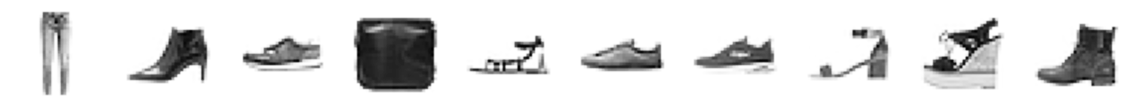

In [ ]:
#Plot the images
for batch_idx, x in train_dataloader:
    show_images(x)
    break

# Data augmentation and pipeline

In [ ]:
# code for data augmentation pipeline 

# Model definitions

In [ ]:
# code for model definitions goes here
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.input_layer = nn.Linear(input_dim, hidden_dim) # can also give a convolutional input
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.sigma_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, batch_input):
        
        
        h = nn.ReLU()(self.input_layer(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.hidden_layer1(z))
        h_o = nn.ReLU()(self.hidden_layer2(h_o))
        
        reconstruction = nn.Sigmoid()(self.out(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma

In [ ]:
#use a convolutional layer in the network


# code for model definitions goes here
class ConvEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, imgChannels =1, featureDim = 32*28*28):
        super(ConvEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 3, stride =1)
        self.encConv2 = nn.Conv2d(16, 32, 3, stride =1)
        self.encFC1 = nn.Linear(featureDim, latent_dim)
        self.encFC2 = nn.Linear(featureDim, latent_dim)

        
        #self.input_layer = nn.Linear(out_channels*32*32, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(featureDim, latent_dim)
        self.sigma_layer = nn.Linear(featureDim, latent_dim)
        
    def forward(self, batch_input):
        
        h = nn.ReLU()(self.encConv1(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.encConv2(h)) 
        #h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        h = h.view(-1, 32*28*28)
        
        
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class ConvDecoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim, imgChannels =1, featureDim = 32*28*28):
        super(ConvDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 3)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 3)

        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.decFC1(z))
        
        h_o = h_o.view(-1, 32,28,28)
        
        h_o = nn.ReLU()(self.decConv1(h_o))

        reconstruction = nn.Sigmoid()(self.decConv2(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class ConvVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvVAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma
    

# Training and validation loop

In [ ]:
def save_model_checkpoint(path, model, optimizer, overall_loss, overall_reconstruction_loss, overall_kl_loss):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "overall_loss_dict": overall_loss,
                 "overall_reconstruction_dict": overall_reconstruction_loss,
                 "overall_kl_loss_dict": overall_kl_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [ ]:
# write your training and validation loop here

# training and validation after every epoch
def train(model, train_loader, num_epochs, save_name):
    best_loss = float("Inf") 
    train_overall_loss, train_recons_loss, train_kl_loss = [], [], []
    cur_step = 0
    train_pred = []
    val_pred = []
    input_dim = 32*32
    batch_size = 10
    cnt = 0

    for epoch in range(num_epochs):
        overall_loss = 0.0 
        overall_recons_loss = 0.0
        overall_kl_loss = 0.0 
        model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, train_data in train_loader:   
            # Forward
            input_tensor = train_data.to(device)
            input_tensor = input_tensor.view(batch_size,32*32)
            optimizer.zero_grad()
            outputs, mu, log_sigma = model.forward(input_tensor)
            loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma)
            overall_loss += loss.item()
            overall_recons_loss  += reconstruction_loss.item()
            overall_kl_loss += kl_loss
            cnt+=1
            
                
            # Backward and optimize
            loss.backward()
            optimizer.step()   
            
        n_datapoints = cnt * batch_size #cnt gives the no of batches \times the batch_size = total_datapoitns
        avg_overall_loss = overall_loss / n_datapoints
        train_overall_loss.append(avg_overall_loss)
        
        avg_recons_loss = overall_recons_loss/ n_datapoints
        train_recons_loss.append(avg_recons_loss)
        
        avg_kl_loss = overall_kl_loss / n_datapoints
        train_kl_loss.append(avg_kl_loss)
        
        print("Train Pass Completed")
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_overall_loss, "\tReconstruction Loss:", avg_recons_loss, "\tKL Loss:", avg_kl_loss)

        if avg_recons_loss < best_loss:
            best_loss = avg_recons_loss
            save_model_checkpoint(save_name, model, optimizer, avg_overall_loss, best_loss,avg_kl_loss )
    
    print("Finished Training") 
    return train_overall_loss, train_recons_loss, train_kl_loss


In [ ]:
# write your training and validation loop here

# training and validation after every epoch
def train_conv(model, train_loader, num_epochs, save_name):
    best_loss = float("Inf") 
    train_overall_loss, train_recons_loss, train_kl_loss = [], [], []
    cur_step = 0
    train_pred = []
    val_pred = []
    input_dim = 32*32
    batch_size = 10
    cnt = 0

    for epoch in range(num_epochs):
        overall_loss = 0.0 
        overall_recons_loss = 0.0
        overall_kl_loss = 0.0 
        model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, train_data in train_loader:   
            # Forward
            input_tensor = train_data.to(device)
            #input_tensor = input_tensor.view(batch_size,32*32)
            optimizer.zero_grad()
            outputs, mu, log_sigma = model.forward(input_tensor)
            loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma)
            overall_loss += loss.item()
            overall_recons_loss  += reconstruction_loss.item()
            overall_kl_loss += kl_loss
            cnt+=1
            
                
            # Backward and optimize
            loss.backward()
            optimizer.step()   
            
        n_datapoints = cnt * batch_size #cnt gives the no of batches \times the batch_size = total_datapoitns
        avg_overall_loss = overall_loss / n_datapoints
        train_overall_loss.append(avg_overall_loss)
        
        avg_recons_loss = overall_recons_loss/ n_datapoints
        train_recons_loss.append(avg_recons_loss)
        
        avg_kl_loss = overall_kl_loss / n_datapoints
        train_kl_loss.append(avg_kl_loss)
        
        print("Train Pass Completed")
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_overall_loss, "\tReconstruction Loss:", avg_recons_loss, "\tKL Loss:", avg_kl_loss)

        if avg_recons_loss < best_loss:
            best_loss = avg_recons_loss
            save_model_checkpoint(save_name, model, optimizer, avg_overall_loss, best_loss,avg_kl_loss )
    
    print("Finished Training") 
    return train_overall_loss, train_recons_loss, train_kl_loss


In [ ]:
#Loss Criterion

def loss_criterion(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [ ]:
# perform training
import torch.optim as optim

device = "cuda:0"

encoder = Encoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10).cuda()
decoder = Decoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32).cuda()

vae = VAE(encoder = encoder, decoder = decoder).cuda()

optimizer = optim.Adam(vae.parameters(), lr = 6e-4)
save_name = f'Vanilla_VAE_z_dim_10.pt'
epochs = 100
obtained_train_overall_loss_vanilla, obtained_train_recons_loss_vanilla, obtained_train_kl_loss_vanilla = train(vae, train_dataloader,
                                                                                        epochs , save_name )


Starting epoch 1
Train Pass Completed
	Epoch 1 	Average Loss:  32.547789686936596 	Reconstruction Loss: 27.210719675797684 	KL Loss: tensor(5.3371, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Vanilla_VAE_z_dim_10.pt
Starting epoch 2
Train Pass Completed
	Epoch 2 	Average Loss:  13.028748666616586 	Reconstruction Loss: 10.052662664120014 	KL Loss: tensor(2.9761, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Vanilla_VAE_z_dim_10.pt
Starting epoch 3
Train Pass Completed
	Epoch 3 	Average Loss:  8.42144767037416 	Reconstruction Loss: 6.37742122386052 	KL Loss: tensor(2.0440, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Vanilla_VAE_z_dim_10.pt
Starting epoch 4
Train Pass Completed
	Epoch 4 	Average Loss:  6.201967337975135 	Reconstruction Loss: 4.643665555220384 	KL Loss: tensor(1.5583, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Vanilla_VAE_z_dim_10.pt
Starting epoch 5
Train Pass Completed
	Epoch 5 	Average Loss:  4.8955468711266

In [ ]:
# perform training
import torch.optim as optim

device = "cuda:0"

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10).cuda()
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32).cuda()

conv_vae = ConvVAE(encoder = encoder, decoder = decoder).cuda()

optimizer = optim.Adam(conv_vae.parameters(), lr = 3e-4)
save_name = f'Conv_VAE_100_z_dim_10.pt'
epochs = 100
obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss = train_conv(conv_vae, train_dataloader,
                                                                                        epochs , save_name )


Starting epoch 1
Train Pass Completed
	Epoch 1 	Average Loss:  38.396600068312424 	Reconstruction Loss: 29.521499950115498 	KL Loss: tensor(8.8751, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100_z_dim_10.pt
Starting epoch 2
Train Pass Completed
	Epoch 2 	Average Loss:  13.803016968066876 	Reconstruction Loss: 9.599645673605112 	KL Loss: tensor(4.2034, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100_z_dim_10.pt
Starting epoch 3
Train Pass Completed
	Epoch 3 	Average Loss:  8.812009331727639 	Reconstruction Loss: 6.008377954727564 	KL Loss: tensor(2.8036, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100_z_dim_10.pt
Starting epoch 4
Train Pass Completed
	Epoch 4 	Average Loss:  6.478481503413274 	Reconstruction Loss: 4.355584292925321 	KL Loss: tensor(2.1229, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100_z_dim_10.pt
Starting epoch 5
Train Pass Completed
	Epoch 5 	Average Loss:  5.11191767

# Inspection, Validation, and Analysis

In [ ]:
# Inspect, validate, and analyse your trained model

In [ ]:
def create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,model_name,num_epochs,log_scale=True):
    # converted_overall_loss = [tensor.detach().item() for tensor in obtained_train_overall_loss]
    # converted_reconstruction_loss = [tensor.detach().item() for tensor in obtained_train_recons_loss]
    converted_kl_loss = [tensor.detach().item() for tensor in obtained_train_kl_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),obtained_train_overall_loss, label = "Overall Loss", color = "blue")
    plt.plot(range(0,num_epochs),obtained_train_recons_loss, label = "Reconstruction Loss", color = "red")
    plt.plot(range(0,num_epochs),converted_kl_loss, label = "KL Loss", color = "orange")


    plt.title('Loss Vs Epochs {Training}', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('Loss (Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()

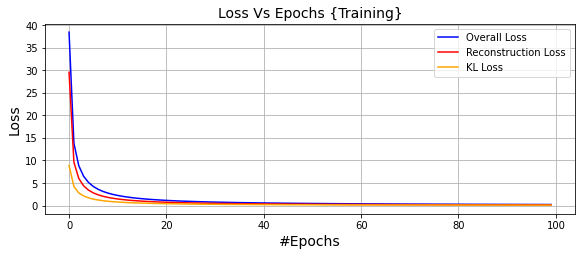

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot for ConvVAE
create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,"ConvVAE",epochs,log_scale=False)

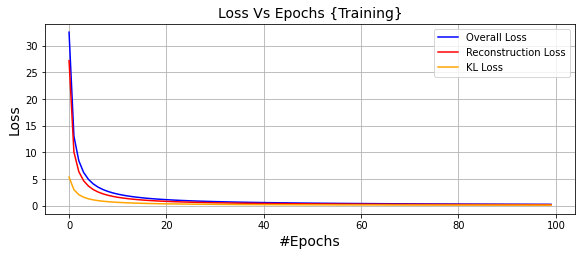

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot for Vanilla VAE

create_loss_plot(obtained_train_overall_loss_vanilla, obtained_train_recons_loss_vanilla, obtained_train_kl_loss_vanilla,"VanillaVAE",epochs,log_scale=False)

In [ ]:
# Generating the images from the sample space
def reconstruct_images(model, data_loader,device='cuda:0'):
    generated_image = []
    original_image = []
    with torch.no_grad():
        model.eval()
        for batch_idx, image in data_loader:
            input_tensor = image.to(device)
            original_image.append(input_tensor)
            outputs = model.forward(input_tensor)
            generated_image.append(outputs)

        return generated_image, original_image

In [ ]:
#Loading the trained model checkpoint and geting back the reconstructions.
device = "cpu"

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10)
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32)

conv_vae = ConvVAE(encoder = encoder, decoder = decoder)

checkpoint = torch.load('Conv_VAE_100_z_dim_10.pt', map_location = 'cpu')
conv_vae.load_state_dict(checkpoint['model_dict'])

gen_image_list, orig_image_list = reconstruct_images(conv_vae,train_dataloader)



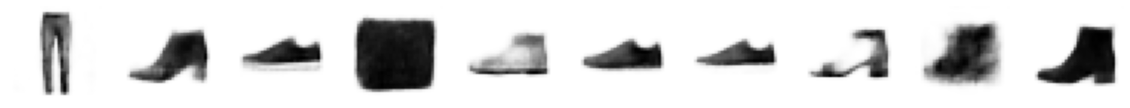

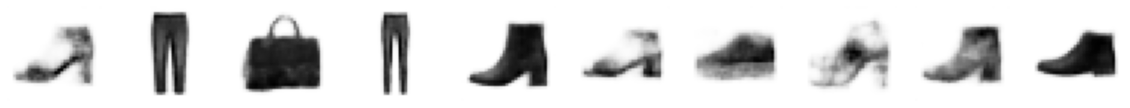

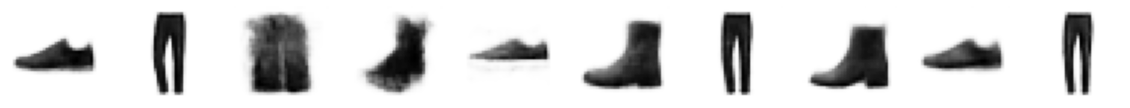

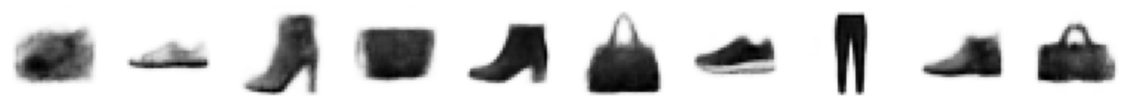

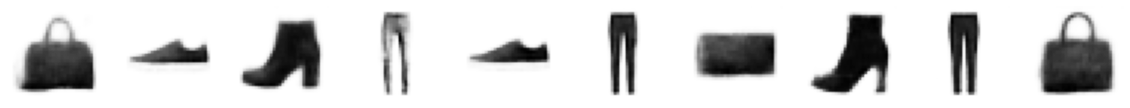

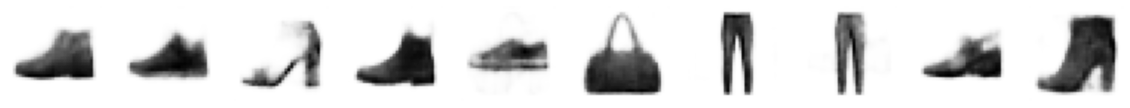

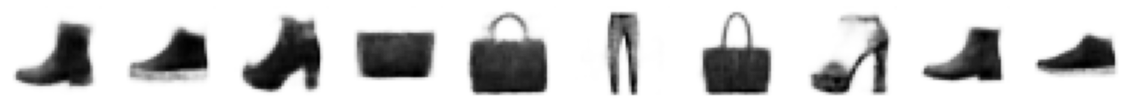

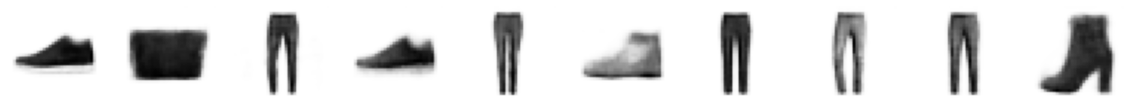

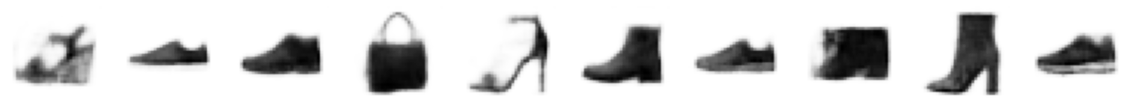

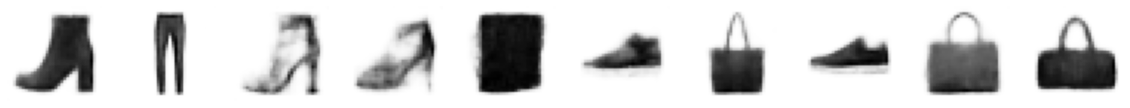

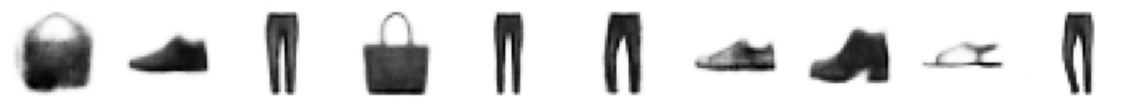

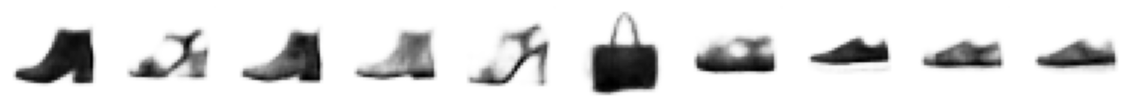

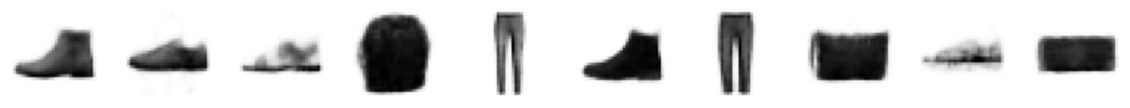

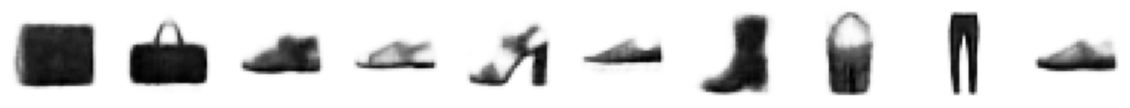

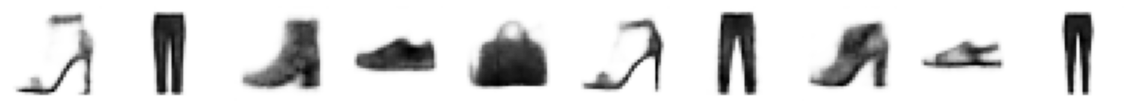

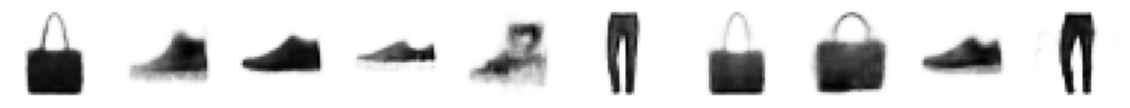

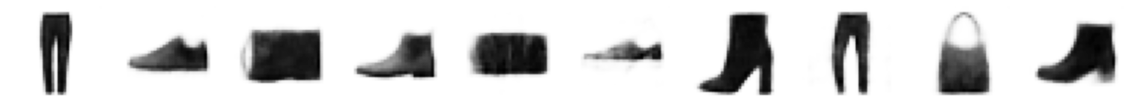

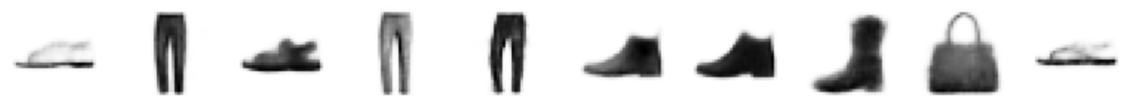

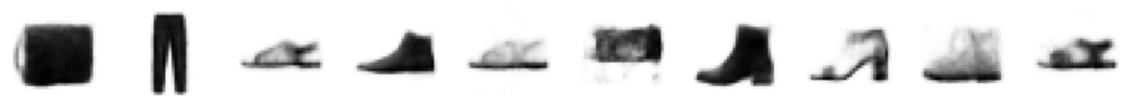

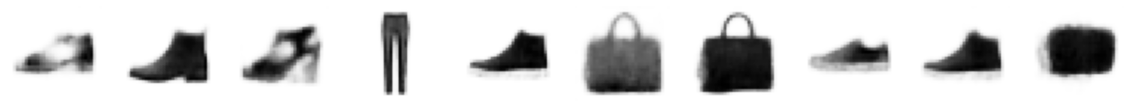

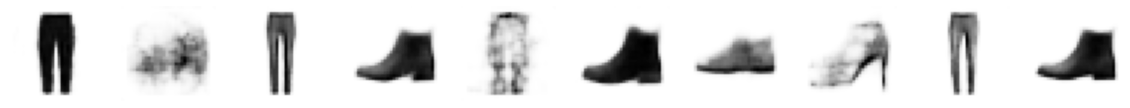

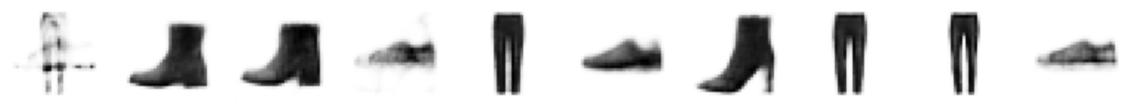

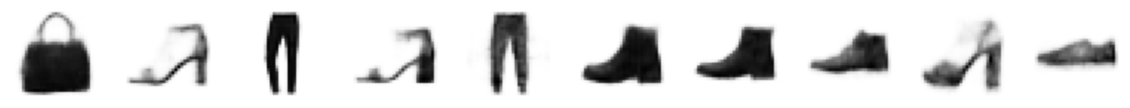

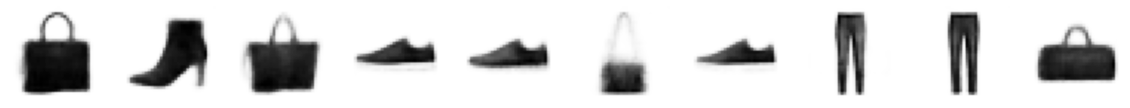

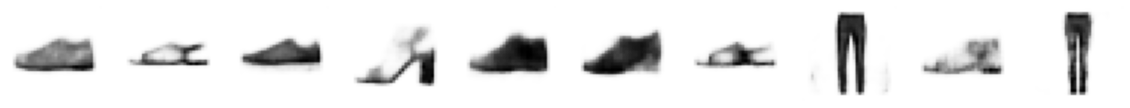

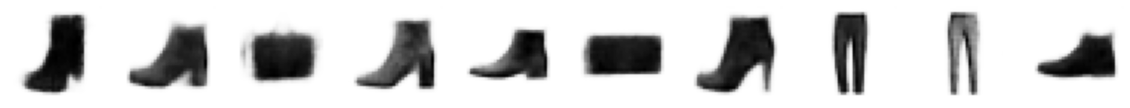

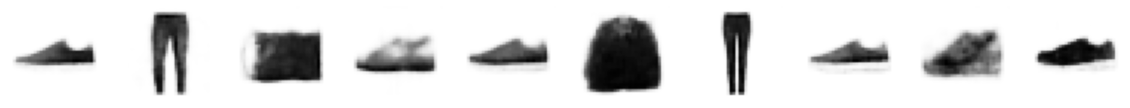

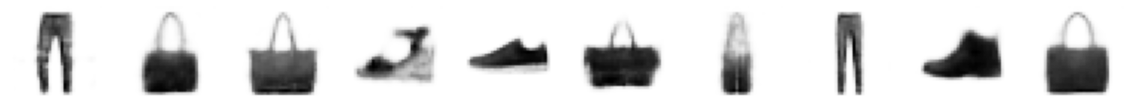

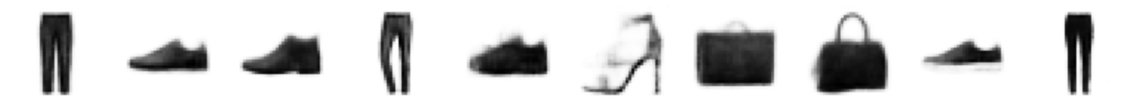

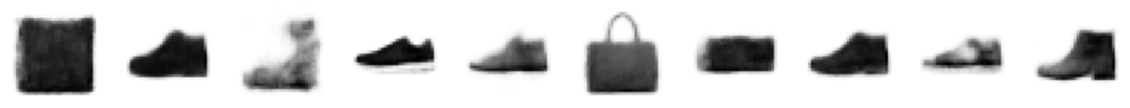

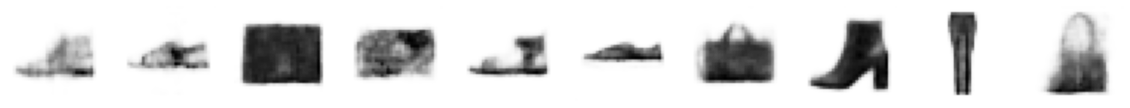

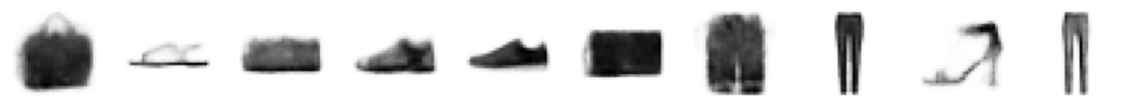

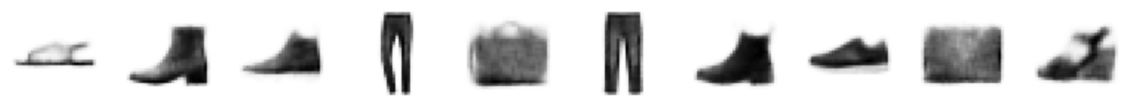

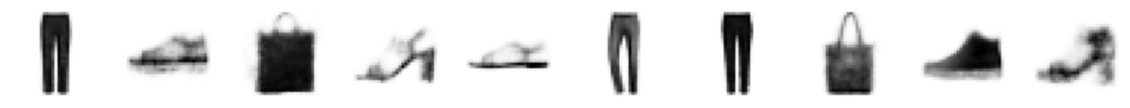

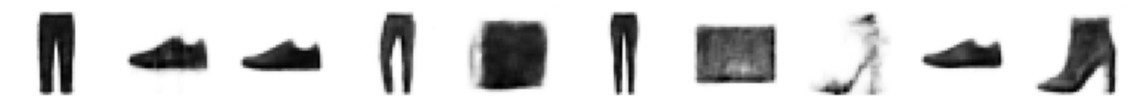

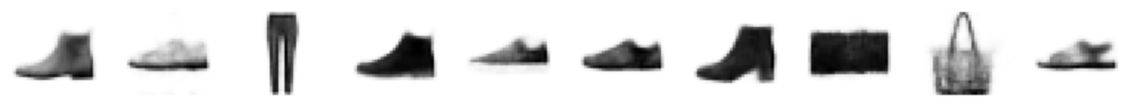

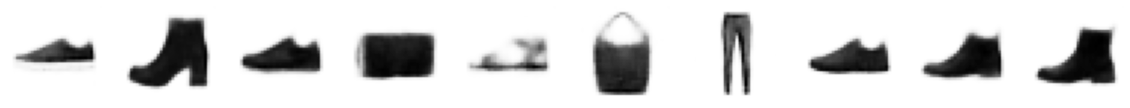

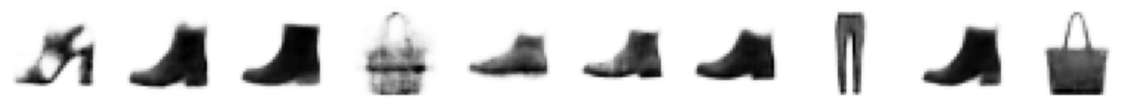

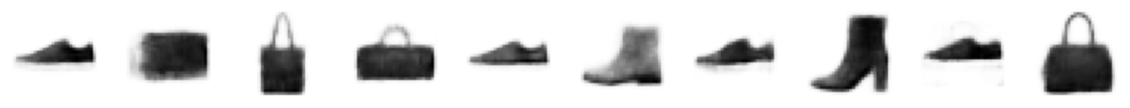

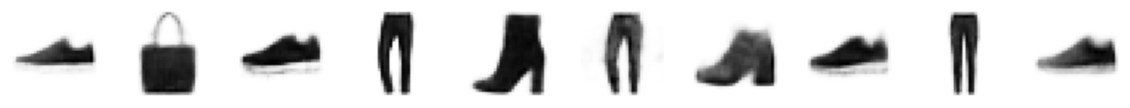

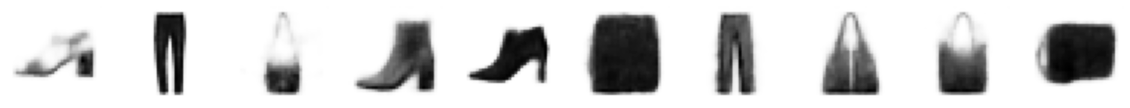

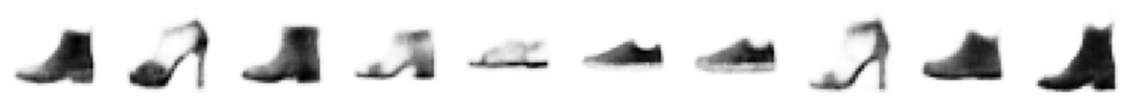

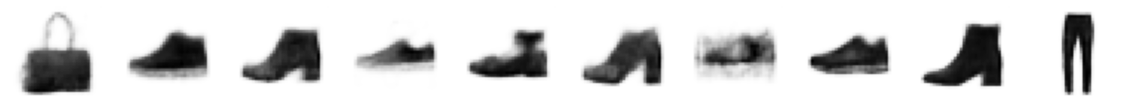

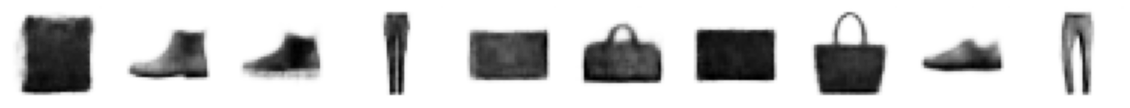

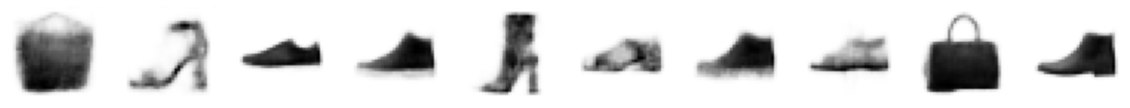

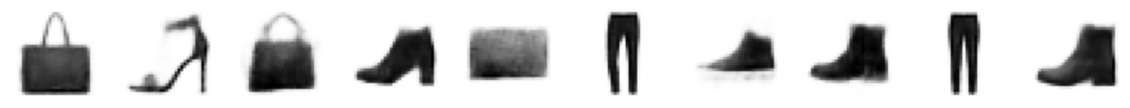

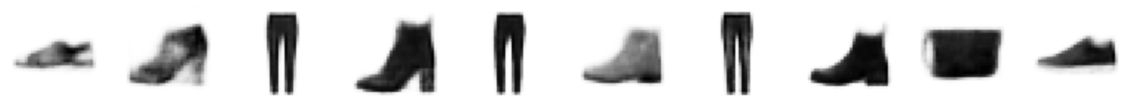

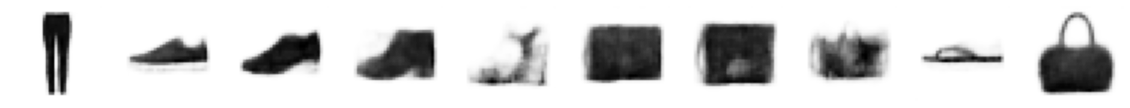

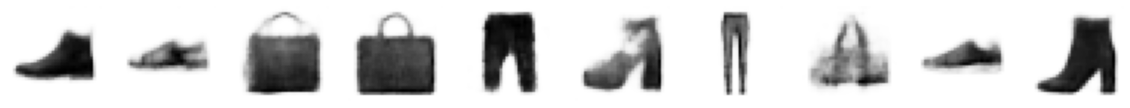

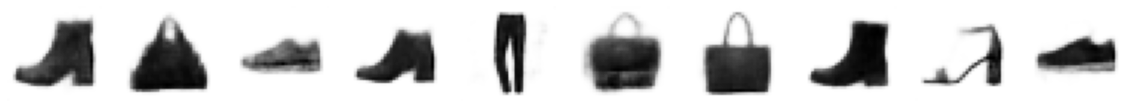

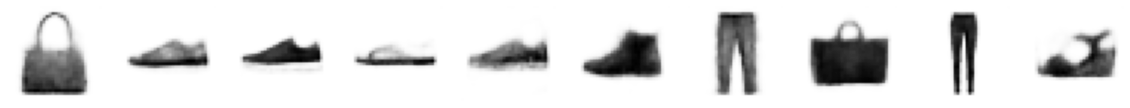

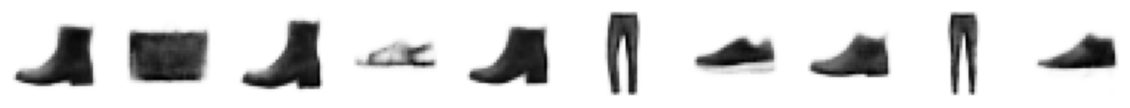

KeyboardInterrupt: ignored

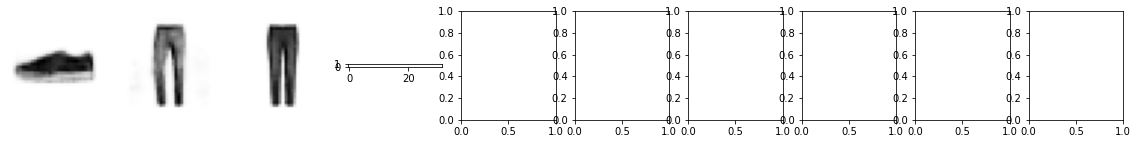

In [ ]:
#Image reconstructions
for x in gen_image_list:
    for y in x:
        try:
            show_images(y)
        except RuntimeError:
            continue

In [ ]:
class VAEClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim, output_dim, latent_dim):
        super(VAEClassifier, self).__init__()
        
        self.encoder = encoder
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.latent_dim = latent_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.out = nn.Linear(hidden_dim, output_dim)
        
        for params in self.encoder.parameters():
            params.requires_grad = False
            
    def forward(self, batch_input):
        
        z_embd, mu, log_sigma = self.encoder(batch_input)
        #print(z_embd[0].shape)
        h = nn.ReLU()(self.hidden_layer1(z_embd))
        h = nn.ReLU()(self.hidden_layer2(h))
        
        output = nn.Softmax()(self.out(h))
        
        return output, z_embd

In [ ]:
#Defining a saving checkpoint for the classifier
def save_model_checkpoint_for_classifier(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))



#Defining a training schedule for the classifier
def train_classifier(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs, z_vector = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            # loss = loss/60
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs, z_vector = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                # loss = loss/60
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint_for_classifier(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     


In [ ]:
import torch.optim as optim

pretrained_encoder = conv_vae.encoder

device = 'cuda:0'
VAE_classifier = VAEClassifier(encoder = pretrained_encoder, hidden_dim = 10, output_dim = 6, latent_dim = 10).cuda()

classifier_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(VAE_classifier.parameters(), lr = 3e-4)
save_name = f'VAE_classifier.pt'
epochs = 100

obtained_train_loss, obtained_val_loss = train_classifier(VAE_classifier, 
                                                      cl_train_dataloader, cl_valid_dataloader, classifier_criterion, epochs, save_name)





Starting epoch 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Pass Completed
Epoch [1/100],Train Loss: 1.7913, Valid Loss: 1.78321481
Model Saved to ==> VAE_classifier.pt
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 1.7770, Valid Loss: 1.76656401
Model Saved to ==> VAE_classifier.pt
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 1.7569, Valid Loss: 1.73749840
Model Saved to ==> VAE_classifier.pt
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 1.7217, Valid Loss: 1.69515038
Model Saved to ==> VAE_classifier.pt
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 1.6740, Valid Loss: 1.63768804
Model Saved to ==> VAE_classifier.pt
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 1.6256, Valid Loss: 1.58705008
Model Saved to ==> VAE_classifier.pt
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 1.5880, Valid Loss: 1.54944944
Model Saved to ==> VAE_classifier.pt
Starting epoch 8
Train Pass Completed
Epoch [8/100],Train Loss: 1.5563, Valid Loss: 1.5241164

In [ ]:
def create_loss_plot_cl(obtained_train_loss, obtained_val_loss, model_name,num_epochs,log_scale=True):
    converted_train_loss = [tensor.detach().item() for tensor in obtained_train_loss]
    converted_val_loss = [tensor.detach().item() for tensor in obtained_val_loss]
    #converted_kl_loss = [tensor.detach().item() for tensor in obtained_train_kl_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),converted_train_loss, label = "Train Loss", color = "blue")
    plt.plot(range(0,num_epochs),converted_val_loss, label = "Validation Loss", color = "red")
    #plt.plot(range(0,num_epochs),converted_kl_loss, label = "KL Loss", color = "orange")


    plt.title('Loss Vs Epochs {VAEClassifier Training}', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('Loss (Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()

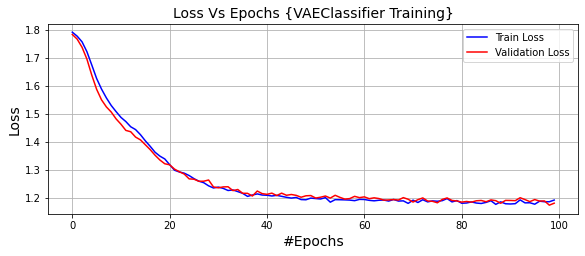

<Figure size 432x288 with 0 Axes>

In [ ]:
create_loss_plot_cl(obtained_train_loss, obtained_val_loss, "VAEClassifier",epochs,log_scale=False)

In [ ]:
def evaluate_test(model, test_loader, criterion, device):
  batch_test_loss = []
  predictions = []
  actual_targets = []
  input_list = []
  test_running_loss = 0

  with torch.no_grad():
    model.eval()

    for input, target in test_loader:
      input_tensor = input.to(device)
      input_list.append(input_tensor)
      outputs, z_embd = model.forward(input_tensor)
      predictions.append(outputs)
      actual_targets.append(target)
      loss = criterion(outputs, target.to(device))
      test_running_loss += loss.item()
      batch_test_loss.append(loss)
    avg_test_loss = test_running_loss/len(test_loader)
    print(f'The Average Test Loss is {avg_test_loss}')
    

    return predictions, actual_targets, batch_test_loss

In [ ]:
preds, targs, obtained_test_loss = evaluate_test(VAE_classifier, cl_test_dataloader, criterion = classifier_criterion, device = "cuda:0")

The Average Test Loss is 1.2010018265247344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


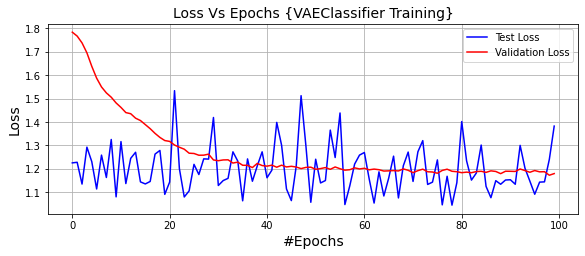

<Figure size 432x288 with 0 Axes>

In [ ]:
create_loss_plot_cl(obtained_test_loss, obtained_val_loss, "VAEClassifier",epochs,log_scale=False)

In [ ]:
len(obtained_test_loss)

100